In [1]:
!pip show imbalanced-learn
import sys
sys.version

Name: imbalanced-learn
Version: 0.11.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: c:\anaconda\lib\site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
!pip install imbalanced-learn


# Imported Libraries


In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [3]:
#val - number of days
def antecedent_rainfall(dr,val):
    for i in range(1,val+1):
        s = "antecedent_"+ str(i) + "days"
        x = i + 1
        dr[s] = np.around(abs(dr.depth.rolling(x).sum() - dr.depth),decimals=7)
        
    return dr
#15days antecedent rainfall
#antecedent_rainfall(dr,180)

# Preprocessing rainfall data (dr)


In [4]:
def preprocessing_of_rainfall_data(data, frequency_of_data):
    data = data.replace(-9999.9, np.nan)
    data.columns = ['time','intensity']
    
    data = data.fillna(0)
    data['depth'] = data['intensity'] * frequency_of_data
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data = data.drop(['intensity'],axis=1)
    
    return data

In [5]:
#Preprocessing rainfall data (dr)
#def preprocessing_of_rainfall_data(data, frequency_of_data):
 #   data = data.replace(-9999.9, np.nan)
  #  data.columns = ['time','intensity']
    
   # data = data.fillna(0)
    #data['depth'] = data['intensity'] * frequency_of_data
    #data['time'] = pd.to_datetime(data['time'])
    #data = data.set_index('time', drop=True)
    #del data.index.name
    
    #data = data.drop(['intensity'],axis=1)
    
    #return data

# Preprocessing landslide data (dl)


In [6]:
def preprocessing_of_landslide_data(data):
    data.columns = ['time','landslide']
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    landslide_years = data.index.year.unique()
    
    return data, landslide_years



# Merging both data  (df)


In [7]:
def merging_both_data(rainfall_data, landslide_data): 
    data = rainfall_data.join(landslide_data)
    
    data = data.fillna(0)
    data = data.drop(columns=['year','month','day'])
    
    
    return data


In [8]:
dr = preprocessing_of_rainfall_data(pd.read_csv('E:/78.9811,30.2587,79.5660,30.5506/RainfallData/TRMM/2003-2019/DailyTRMM.csv'), 24)
dl, landslide_years = preprocessing_of_landslide_data(pd.read_csv('E:/78.9811,30.2587,79.5660,30.5506/LandslideData/Landslide - Sheet2.csv'))

In [9]:
df = merging_both_data(dr,dl)

In [10]:
df = antecedent_rainfall(df,30)

In [11]:
df = df.dropna(axis=0)

# The classes are heavily skewed we need to solve this issue later.


In [12]:
print('No Frauds', round(df['landslide'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['landslide'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 98.85 % of the dataset
Frauds 1.15 % of the dataset


Text(0.5, 1.0, 'Landslide Distributions \n (0: No Landslide || 1: Landslide)')

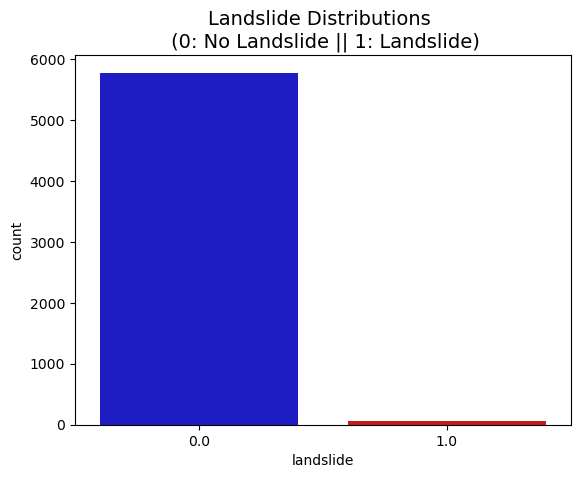

In [13]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('landslide', data=df, palette=colors)
plt.title('Landslide Distributions \n (0: No Landslide || 1: Landslide)', fontsize=14)

In [14]:
df.head()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2003-03-31,0.00,0.0,1.44,5.04,5.04,5.04,5.04,354.239981,464.399985,473.759984,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-01,0.00,0.0,0.00,1.44,5.04,5.04,5.04,5.040000,354.239981,464.399985,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-02,0.00,0.0,0.00,0.00,1.44,5.04,5.04,5.040000,5.040000,354.239981,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-03,0.00,0.0,0.00,0.00,0.00,1.44,5.04,5.040000,5.040000,5.040000,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-04,5.76,0.0,0.00,0.00,0.00,0.00,1.44,5.040000,5.040000,5.040000,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984


 Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)


In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()


for i in df.columns:
    if i != 'landslide':
        df[i] = rob_scaler.fit_transform(df[i].values.reshape(-1,1))

In [16]:
df.head()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2003-03-31,0.0,0.0,0.025,0.021277,-0.006656,-0.040975,-0.072169,0.229620,0.235712,0.159465,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-01,0.0,0.0,0.000,0.006079,-0.006656,-0.040975,-0.072169,-0.099864,0.148706,0.153259,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-02,0.0,0.0,0.000,0.000000,-0.014975,-0.040975,-0.072169,-0.099864,-0.127097,0.080210,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-03,0.0,0.0,0.000,0.000000,-0.018303,-0.046512,-0.072169,-0.099864,-0.127097,-0.151349,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-04,0.1,0.0,0.000,0.000000,-0.018303,-0.048726,-0.076317,-0.099864,-0.127097,-0.151349,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189


# StratifiedShuffleSplit 
is a cross-validation technique used in machine learning to split a dataset into training and test sets while ensuring that the class distribution of the target variable (or any categorical variable of interest) is preserved in both the training and test sets. It is particularly useful when dealing with imbalanced datasets, where some classes have significantly fewer examples than others.

We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Landslide', round(df['landslide'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Landslide', round(df['landslide'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('landslide', axis=1)
y = df['landslide']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Landslide 98.85 % of the dataset
Landslide 1.15 % of the dataset
Train: [4106 2055 2593 ... 3119 3695 5074] Test: [1809  470 2495 ...  814 1962 1139]
Train: [2795 2449 5347 ... 4830 3033 5727] Test: [2528 5458 2381 ...  488  968 2065]
Train: [ 334 2632 3907 ... 2478 1989 3928] Test: [3464 1875 2435 ... 1280 5221  432]
Train: [1352 1476 2457 ... 3163 1928 5803] Test: [2888 2788 2206 ... 3330 2058 5745]
Train: [5186  147 4749 ... 1169 1072 2190] Test: [ 279 4830 4951 ...  433  102 1676]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.98844178 0.01155822]
[0.98887938 0.01112062]


In [18]:
df.describe()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,...,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,2.267678,0.011471,2.267682,1.102827,0.887038,0.754585,0.674135,0.634534,0.590800,0.537987,...,0.430867,0.423053,0.416466,0.409844,0.398031,0.386365,0.384384,0.380091,0.387040,0.385461
std,6.319794,0.106494,6.319793,2.515516,1.847539,1.516611,1.339474,1.256701,1.184168,1.104429,...,0.983112,0.968853,0.956996,0.944745,0.922014,0.922087,0.917778,0.909304,0.932223,0.929117
min,0.000000,0.000000,0.000000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.131078,-0.154691,...,-0.303355,-0.306132,-0.309124,-0.311645,-0.310970,-0.327329,-0.330462,-0.332561,-0.347914,-0.351300
25%,0.000000,0.000000,0.000000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.131078,-0.154691,...,-0.255061,-0.255049,-0.254240,-0.251140,-0.247400,-0.261031,-0.258048,-0.260140,-0.267626,-0.270043
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.981697,0.951274,0.922024,0.895380,0.868922,0.845309,...,0.744939,0.744951,0.745760,0.748860,0.752600,0.738969,0.741952,0.739860,0.732374,0.729957
max,105.393742,1.000000,105.393742,29.563831,22.330282,15.767442,14.522605,12.430368,10.870628,10.033660,...,7.444188,7.288952,7.100809,7.183755,6.981547,7.230682,7.344186,7.244070,7.228496,7.085726


# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

In [19]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
landslide_df = df.loc[df['landslide'] == 1]
non_landslide_df = df.loc[df['landslide'] == 0][:67]

normal_distributed_df = pd.concat([landslide_df, non_landslide_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2018-09-08,0.731250,0.0,0.156250,2.136778,1.590682,1.098007,1.012028,1.004076,0.924083,0.877298,...,0.657606,0.628712,0.752370,0.847990,0.783017,0.804586,0.908533,0.934246,0.913493,0.877167
2010-09-22,3.075000,1.0,1.075000,0.261398,1.694675,4.589701,3.715471,3.117188,2.652545,2.325376,...,1.825140,1.781139,1.706532,1.647824,1.540152,1.484901,1.417476,1.372561,1.485920,1.425785
2018-05-03,0.000000,0.0,13.512500,4.068389,2.538269,1.772979,1.613024,1.488112,1.202161,0.965863,...,0.151244,0.124829,0.182917,0.157895,0.131988,0.104745,0.086649,0.104070,0.090071,0.073131
2015-08-15,27.668748,1.0,0.000000,0.100304,1.183028,0.832780,1.344255,2.223506,1.876884,1.996658,...,1.704550,1.665448,1.766809,2.105595,2.193838,2.360176,2.571574,2.638737,2.748934,2.872968
2010-07-06,31.431248,1.0,88.637501,29.563831,18.521630,12.290698,9.214849,7.691917,6.395223,5.324660,...,2.311066,2.172348,2.049926,1.936345,1.809758,1.728374,1.667859,1.588491,1.631123,1.566495


Distribution of the Classes in the subsample dataset
0.0    0.5
1.0    0.5
Name: landslide, dtype: float64


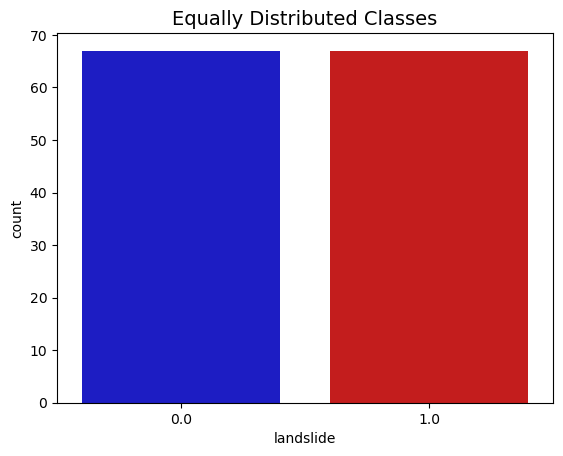

In [20]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['landslide'].value_counts()/len(new_df))



sns.countplot('landslide', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

# Make sure we use the subsample in our correlation


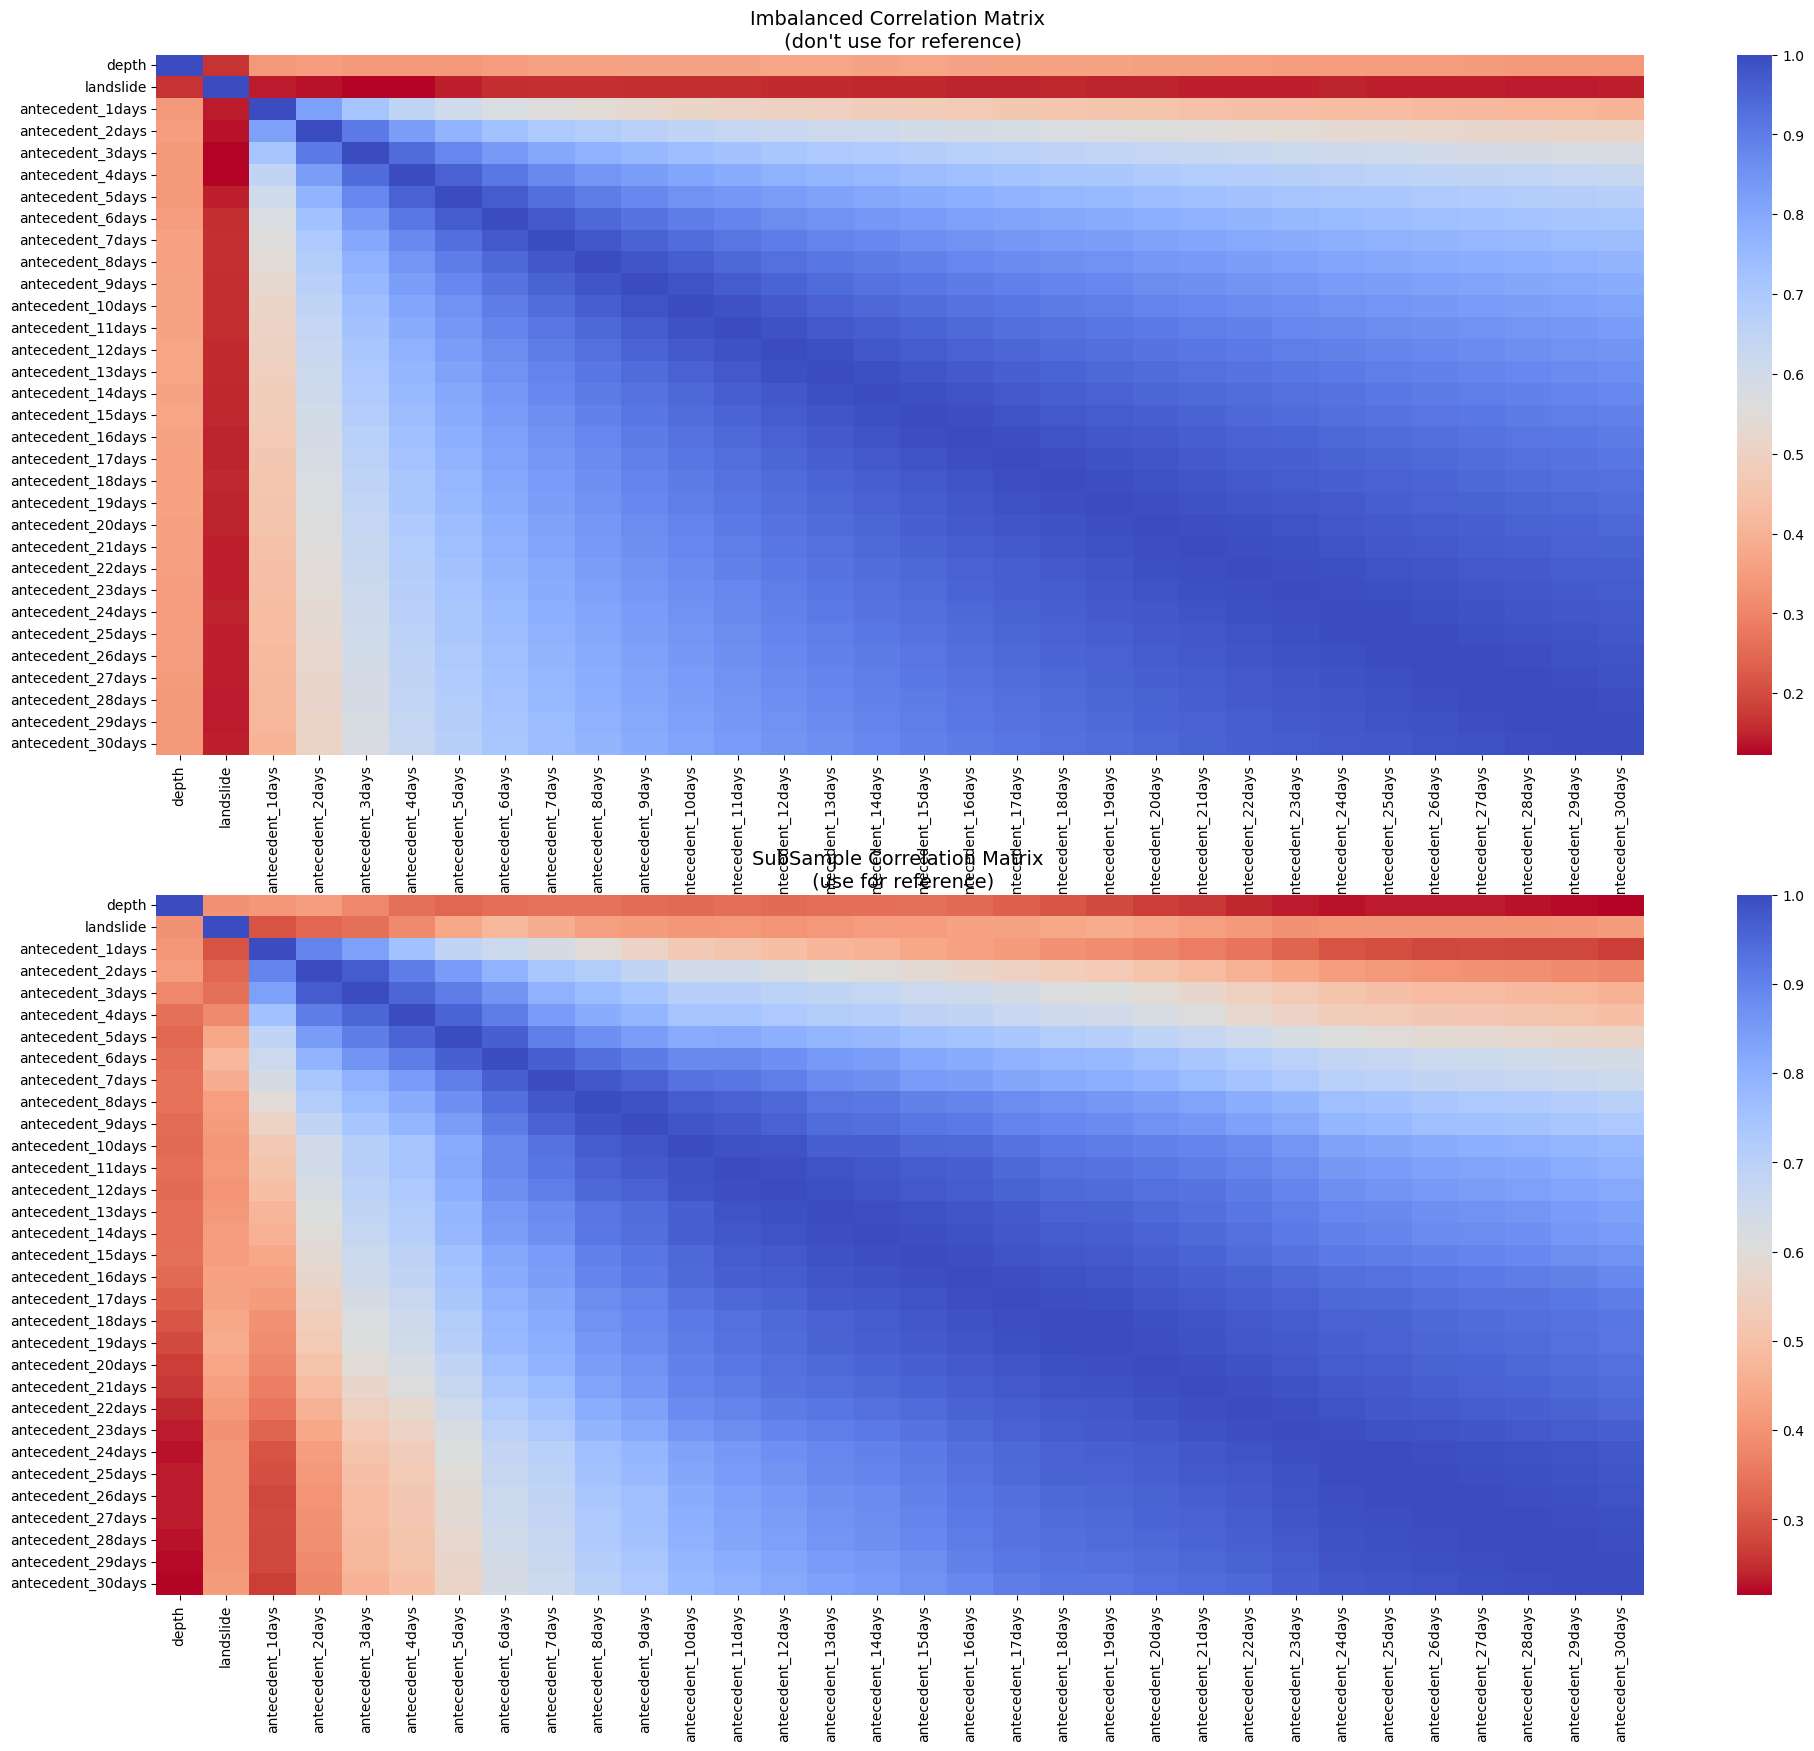

In [21]:

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

# lets ruduce the dimentionality for our data while securing the features

In [23]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('landslide', axis=1)
y = new_df['landslide']

# since our data is multi dimentional reducing the dimensionality of high-dimensional data while preserving the structure
# and relationships between data points lets use T-SNE 
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))
#Principal Component Analysis (PCA) is a dimensionality reduction technique used in data analysis and machine learning to 
#reduce the number of features (variables) in a dataset while preserving as much of the variance in the data as possible.
#PCA achieves this by transforming the original features into a new set of uncorrelated variables called principal components. 
# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))
#Truncated Singular Value Decomposition (TruncatedSVD) is a dimensionality reduction technique closely related to 
#Principal Component Analysis (PCA), but it operates on sparse data and is typically used for linear dimensionality 
#reduction when working with large and sparse datasets.
# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 0.93 s
PCA took 0.095 s
Truncated SVD took 0.004 s


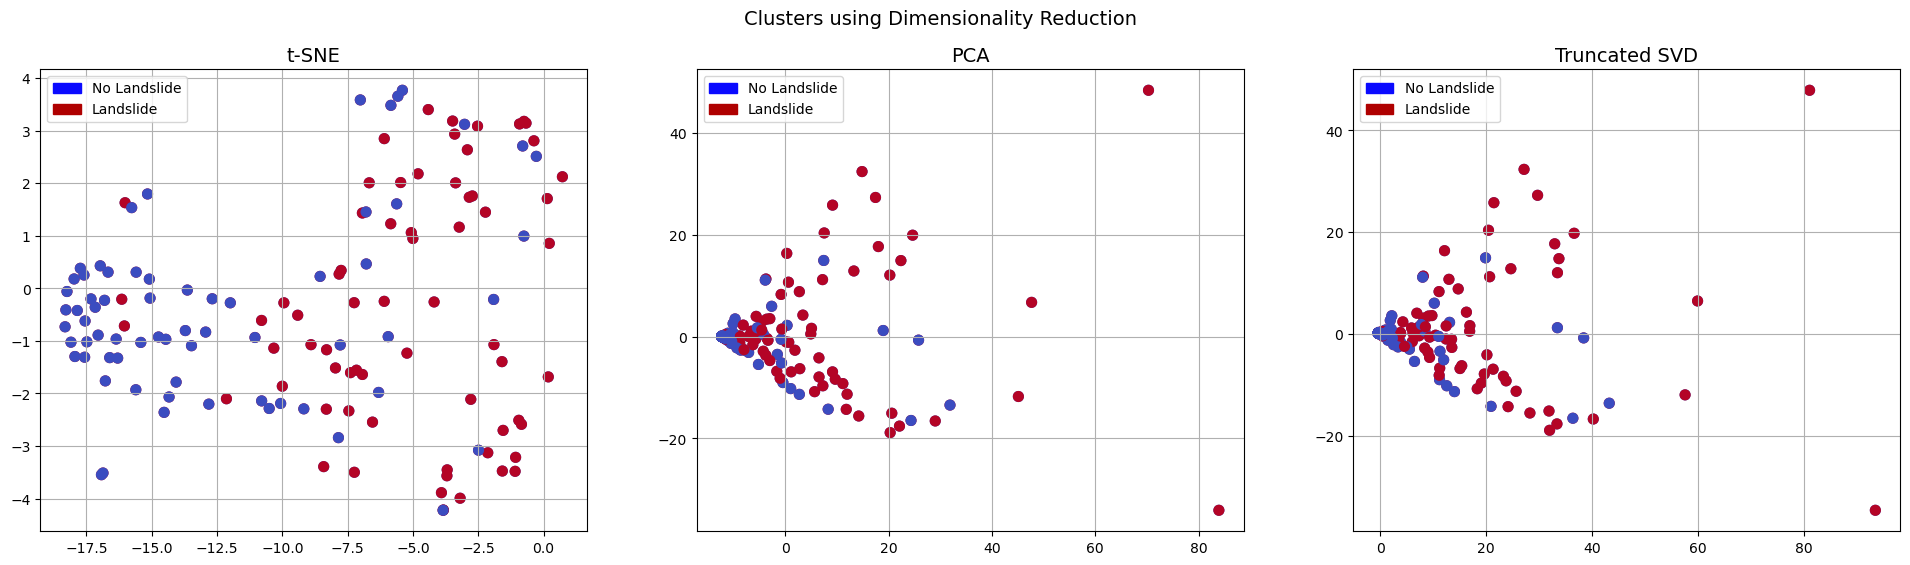

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Landslide')
red_patch = mpatches.Patch(color='#AF0000', label='Landslide')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Landslide', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Landslide', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Landslide', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Landslide', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Landslide', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Landslide', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Undersampling before cross validating (prone to overfit)


In [25]:
X = new_df.drop('landslide', axis=1)
y = new_df['landslide']

# Our data is already scaled we should split our training and test sets


In [26]:
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.


In [27]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Let's implement simple classifiers


In [28]:

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# our scores are getting even high scores even when applying cross validation.


In [29]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 82.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 79.0 % accuracy score
Classifiers:  SVC Has a training score of 78.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 67.0 % accuracy score


In [30]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

# Overfitting Case
Overfitting occurs when a model learns the details and noise in the training data to the extent that it negatively impacts its performance on new, unseen data. In other words, an overfit model captures the noise in the training data, rather than the underlying pattern. This often leads to poor generalization, where the model performs well on the training data but fails to make accurate predictions on new, unseen data.

lets find the cross validation scores of all the 4 models

In [31]:

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  82.25%
Knears Neighbors Cross Validation Score 76.67%
Support Vector Classifier Cross Validation Score 84.11%
DecisionTree Classifier Cross Validation Score 74.72%


# undersample during cross validating

Undersampling during cross-validation addresses class imbalance by ensuring equal representation of both classes in training folds. In situations where one class dominates, randomly selecting a subset of majority class samples for each fold balances the dataset. This promotes fairer model evaluation, preventing bias towards the majority class and improving overall accuracy.

In [33]:
undersample_X = df.drop('landslide', axis=1)
undersample_y = df['landslide']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [4113 2078 2622 ... 3128 3707 5078] Test: [1829  475 2522 ...  823 1983 1151]
Train: [2811 2476 5349 ... 4832 3044 5727] Test: [2555 5461 2407 ...  493  979 2088]
Train: [ 338 2663 3911 ... 2505 2010 3933] Test: [3474 1895 2462 ... 1293 5222  437]
Train: [1365 1491 2484 ... 3174 1949 5803] Test: [2904 2803 2231 ... 3342 2081 5745]
Train: [5187  149 4752 ... 1182 1084 2215] Test: [ 282 4832 4953 ...  438  102 1689]
NearMiss Label Distribution: Counter({0.0: 67, 1.0: 67})


# Let's Plot the Learning Curves


In [41]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#0000FF")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#0000FF",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

# lets score all the 4 learning curves and observe 

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

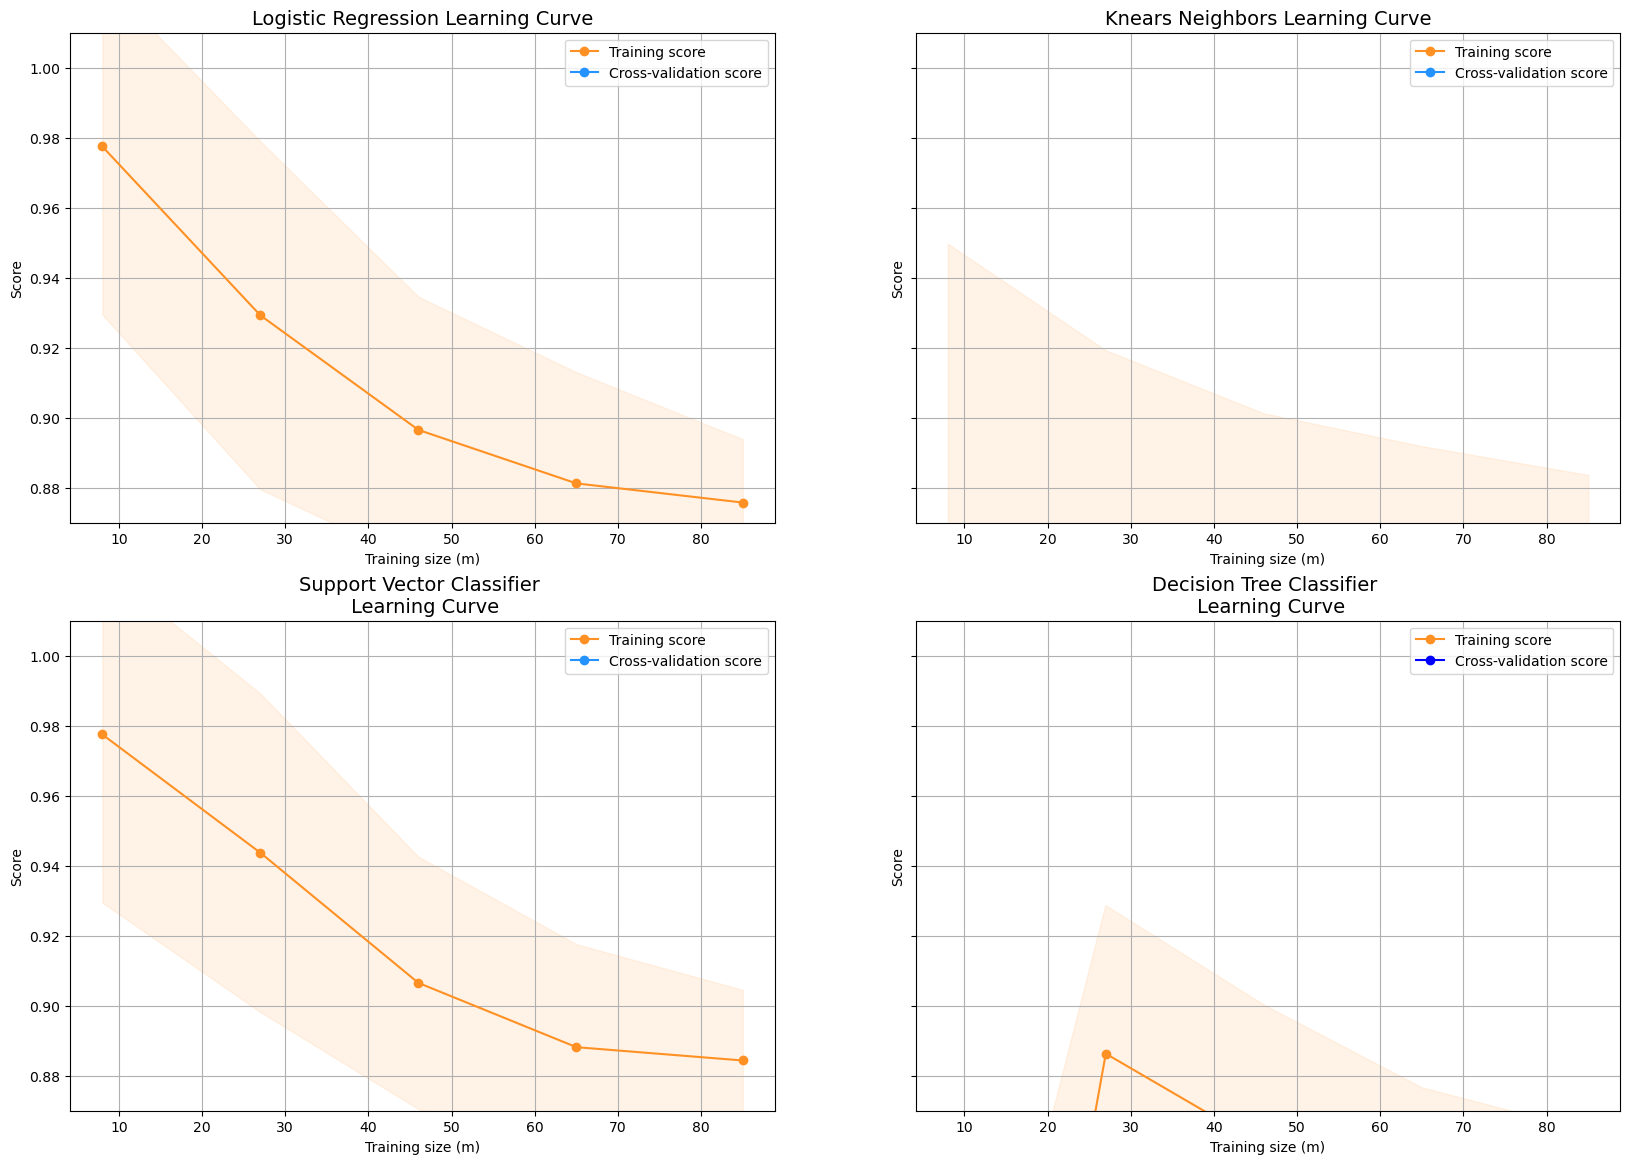

In [42]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)